In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import main_single
from os.path import exists
import argparse
import matplotlib.pyplot as plt
import pandas as pd
import os, fnmatch

from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.io import curdoc
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

## Output comparison
I would compare two type of deep learning methods:
1. vae-rnn
2. vanila gru
3. _(maybe transformer in the future)_

and adding physical constraints:
1. pure black box methods
2. the measurement model is known
  a. soft constraints: as panelty
  b. soft constraints: as prior (for variance inference)
  c. hard constraints: inserted in decoder
3. part of dynamic model is known
  a. hard constraints: mean decoder = __nn_dec+phy+dec__
4. _(assume the model is nn+phy+gaussian)_, so we have three blocks one of which is 2d measuring the mean and variance for the normal distribution
__notice:__ VAE is chosen here because of the uncertainty in our stochastic model, while we could extract mean and variance which makes the Gaussian noise measurable


We do not care the "best" structure, the mean idea is to show the physics knowledge can improve the performance


__notice:__ improvement is possible not only in _rmse_, but also in _model size_, _vaf_

#### 30 apr 2024:

Today I write the function for plotting and compared two different activation function relu() (__this is better__) and tanh()

Continued yesterday's rnn structure, yesterday I get bad results because of no activation function

```
nohup python main_single.py --n_epoch=800 --model='AE-RNN' --h_dim=80 --z_dim=2 --dataset='toy_lgssm' --logdir='test_relu' --mpnt_wt=0 --do_test --do_train &

nohup python main_single.py --n_epoch=800 --model='AE-RNN' --h_dim=80 --z_dim=2 --dataset='toy_lgssm_5_pre' --logdir='test_relu' --mpnt_wt=0 --do_test --do_train &
```
- It is wired that toy_logssm (the random training set) has worse performance (__1.8__) than the existing dataset toy_lgssm_5_pre (__1.56__)  _hdim = 80, zdim=2_

## code implementation
- plot the estimation (y_hat) and true lable (y)
- 

In [2]:
def plot_k_nn_y(y, y_hat, rmse, panelty,h_dim,length=50,start_from=0):
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, length +1), y[start_from:start_from+length], linestyle='-',color='red',label='y_true')
    plt.plot(range(1, length +1), y_hat[start_from:start_from+length], linestyle='-',color='blue',label='y_estimate')
    lower_bound =  y[start_from:start_from+length]-y_hat[start_from:start_from+length]
    upper_bound = -y[start_from:start_from+length]+y_hat[start_from:start_from+length]
    
    # plt.plot(range(1, length +1), y[start_from:start_from+length]-y_hat[start_from:start_from+length], linestyle='-',color='red',label='residual')
    plt.fill_between(range(1, length +1), lower_bound, upper_bound, color='gray', alpha=0.3, label='Shaded Region')
    plt.xlabel('k step')
    plt.ylabel('value')
    plt.title('rmse={}, panelty={}, h_dim={}'.format(rmse,panelty,h_dim))
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.show()

def plot_k_nn_y_rsd(y, y_hat, rmse, panelty,h_dim,length=50,start_from=0):
    plt.figure(figsize=(12, 5))
    lower_bound =  y[start_from:start_from+length]-y_hat[start_from:start_from+length]
    upper_bound = -y[start_from:start_from+length]+y_hat[start_from:start_from+length]
    window_size = 5
    smoothed_y_res = np.convolve(lower_bound, np.ones(window_size)/window_size, mode='valid')
    # plt.plot(range(1, length +1), y[start_from:start_from+length]-y_hat[start_from:start_from+length], linestyle='-',color='red',label='residual')
    plt.fill_between(range(1, length +1), lower_bound, upper_bound, color='gray', alpha=0.3, label='Shaded Region')
    plt.plot(range(1, length +1)[window_size-1:], smoothed_y_res, label='Smoothed')
    plt.xlabel('k step')
    plt.ylabel('value')
    plt.title('rmse={}'.format(rmse,panelty,h_dim))
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.show()

def y_yhat_nn(pattern, rmse_path, panelty,h_dim,length = 100,start_from=0):

    # model_name = "VAE-RNN_None"
    # path = project_path+log_path+model_name+test_output_path

    df = pd.read_csv(pattern)
    df.head()

    u=df['u_test_0'].to_numpy().transpose()
    u=np.expand_dims(u, axis=0)
    y=df['y_test_0'].to_numpy().transpose()
    # y=np.expand_dims(y, axis=0)
    y_hat = df["y_sample_mu_0"].to_numpy().transpose()
    # y_hat=np.expand_dims(y_hat, axis=0)
    print(y,y_hat)
    df_rmse = pd.read_csv(rmse_path)
    rmse = df_rmse["rmse"][0]
    print(rmse)
    vaf = df_rmse["vaf"]
    
    plot_k_nn_y(y, y_hat, rmse, panelty,h_dim, length,start_from)
    plot_k_nn_y_rsd(y, y_hat, rmse, panelty,h_dim, length,start_from)
    # run_toy_lgssm_sim

# pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h{}_z2_n1.csv"
def read_rsme(pattern, h_dim_max):
    rmse_value = []
    for i in range(1,h_dim_max+1):
        df = pd.read_csv(pattern.format(i))
        rmse_value.append(df["rmse"].mean()) 
    return rmse_value

def read_rsme_every_5(pattern, h_dim_max ):
    rmse_value = []
    for i in range(2,h_dim_max+1):
        df = pd.read_csv(pattern.format(i*5))
        # print(i*5,df["rmse"])
        rmse_value.append(df["rmse"].mean()) 
    return rmse_value
    
def read_std(pattern, h_dim_max):
    std_value = []
    for i in range(2,h_dim_max+1):
        df = pd.read_csv(pattern.format(i))
        std_value.append(df["rmse"].std()) 
    return std_value

def read_std_every_5(pattern, h_dim_max ):
    std_value = []
    for i in range(2,h_dim_max+1):
        df = pd.read_csv(pattern.format(i*5))
        std_value.append(df["rmse"].std()) 
    return std_value




[-0.49565518 -1.1304687  -0.61903954 ...  4.462914    4.948224
  3.9643989 ] [-1.2830224  -0.40986267 -1.4119698  ...  1.1228303   2.5706315
  4.4201913 ]
1.7279901504516602


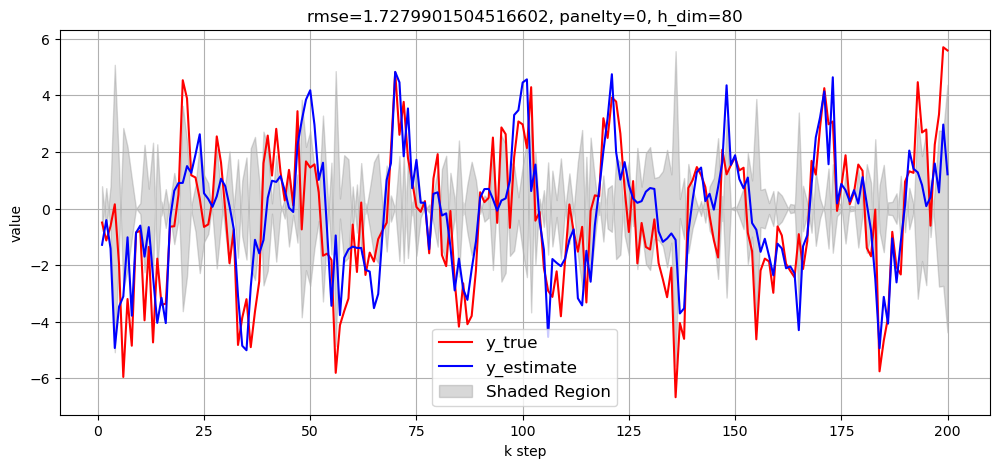

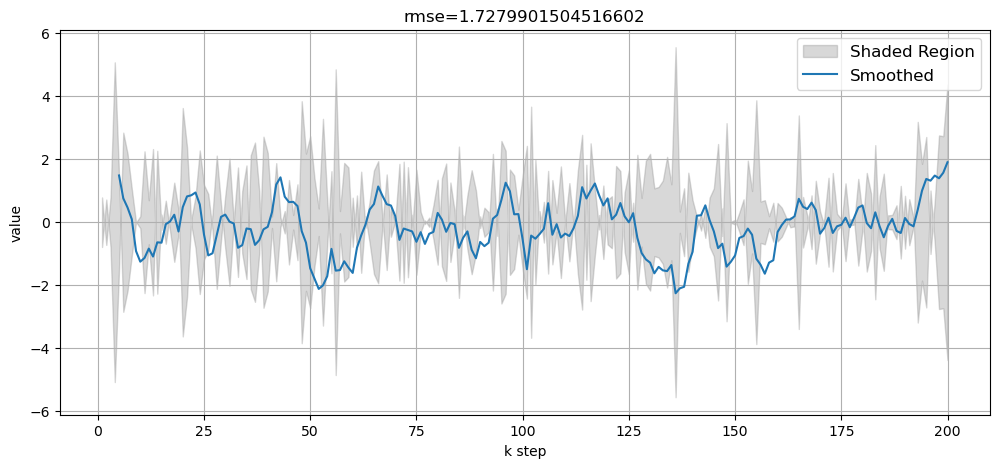

In [20]:

pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm_5_pre/AE-RNN_None/toy_lgssm_5_pre_h20_z2_n1_A0_B0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm_5_pre/AE-RNN_None/data/toy_lgssm_5_pre_h20_z2_n1_A0_B0.csv"
y_yhat_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 200, start_from=0)

[-0.49565518 -1.1304687  -0.61903954 ...  4.462914    4.948224
  3.9643989 ] [-0.17095007  0.15433809 -0.4179117  ...  2.2036924   2.501062
  4.044744  ]
1.558018684387207


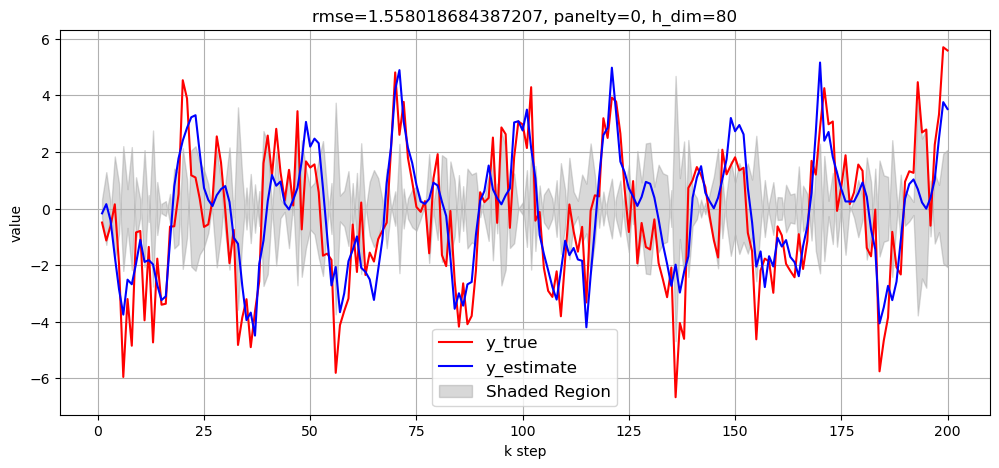

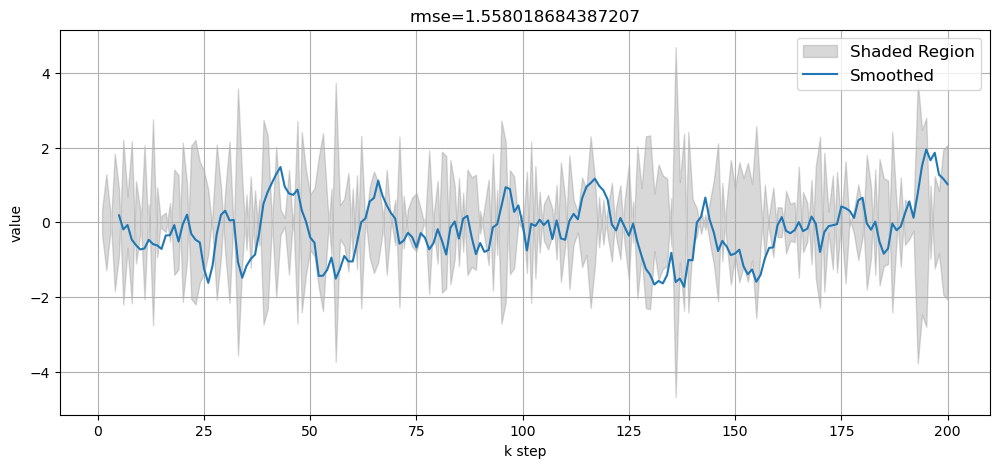

In [22]:

pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm_5_pre/AE-RNN_None/toy_lgssm_5_pre_h80_z10_n1_A0_B0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm_5_pre/AE-RNN_None/data/toy_lgssm_5_pre_h80_z10_n1_A0_B0.csv"
y_yhat_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 200, start_from=0)

[-0.49565518 -1.1304687  -0.61903954 ...  4.462914    4.948224
  3.9643989 ] [ 1.6850454e-01 -3.5505886e-03 -1.0433804e+00 ...  2.1727934e+00
  2.9511573e+00  4.5901337e+00]
1.5615674257278442


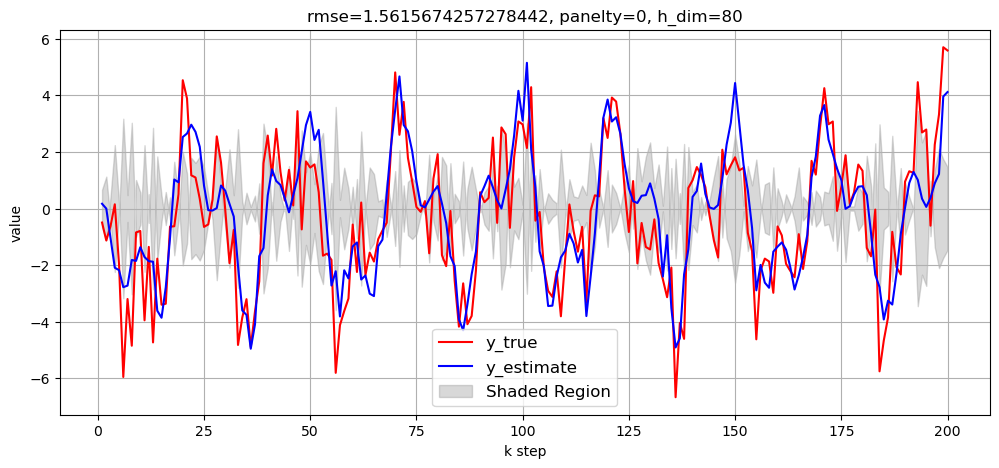

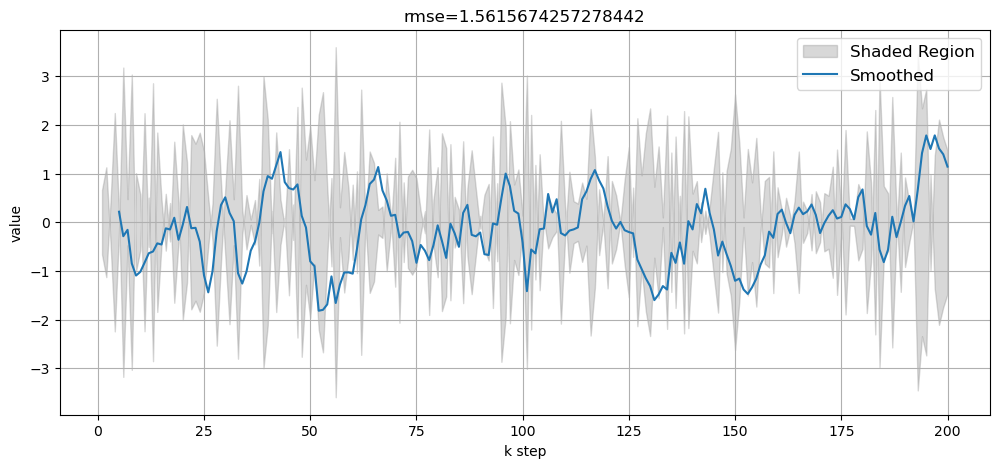

[-0.49565518 -1.1304687  -0.61903954 ...  4.462914    4.948224
  3.9643989 ] [ 1.6850454e-01 -3.5505886e-03 -1.0433804e+00 ...  2.1727934e+00
  2.9511573e+00  4.5901337e+00]
1.5615674257278442


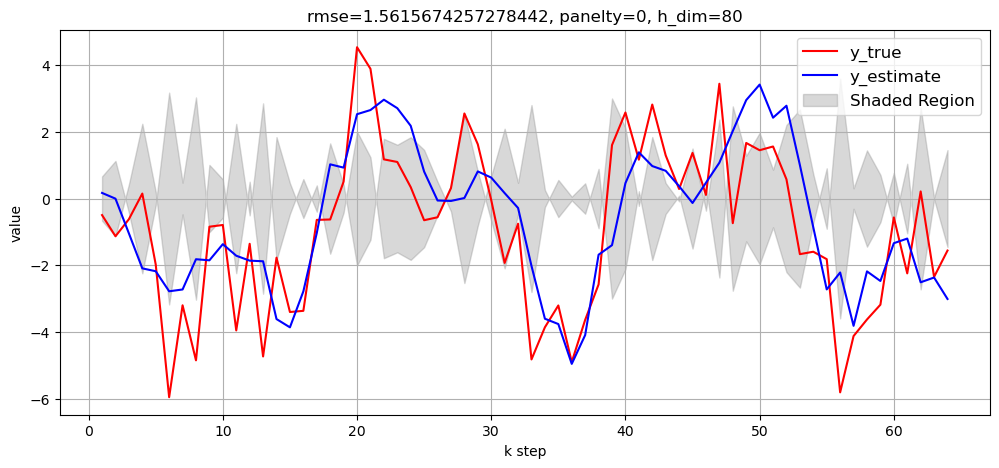

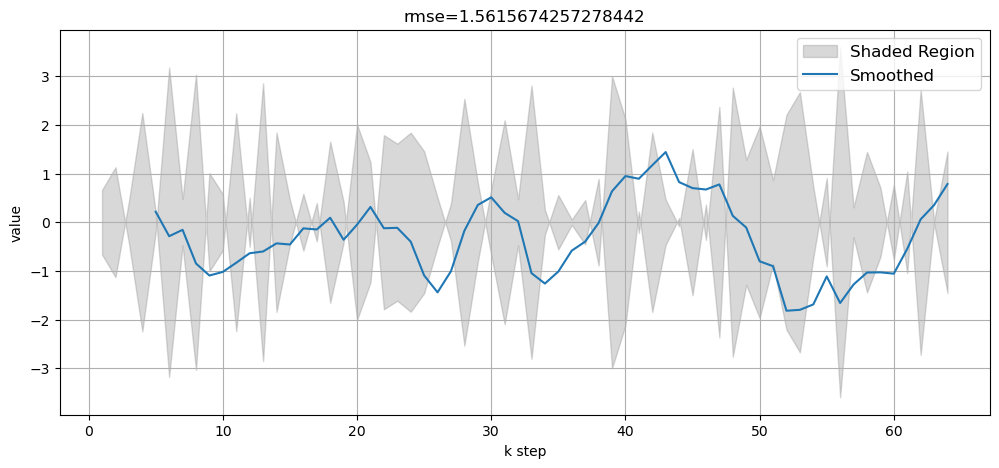

In [26]:


pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm_5_pre/AE-RNN_None/toy_lgssm_5_pre_h80_z2_n1_A0_B0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm_5_pre/AE-RNN_None/data/toy_lgssm_5_pre_h80_z2_n1_A0_B0.csv"
y_yhat_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 200, start_from=0)
y_yhat_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 64, start_from=0)

[-0.49565518 -1.1304687  -0.61903954 ...  4.462914    4.948224
  3.9643989 ] [-0.10366278  0.2380903  -0.33885065 ...  2.5436184   2.814575
  4.9169784 ]
1.8430859647849929


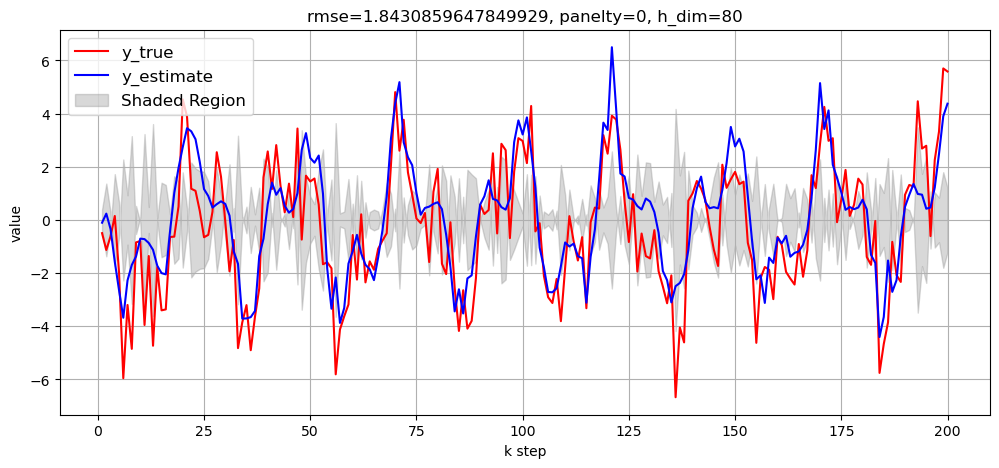

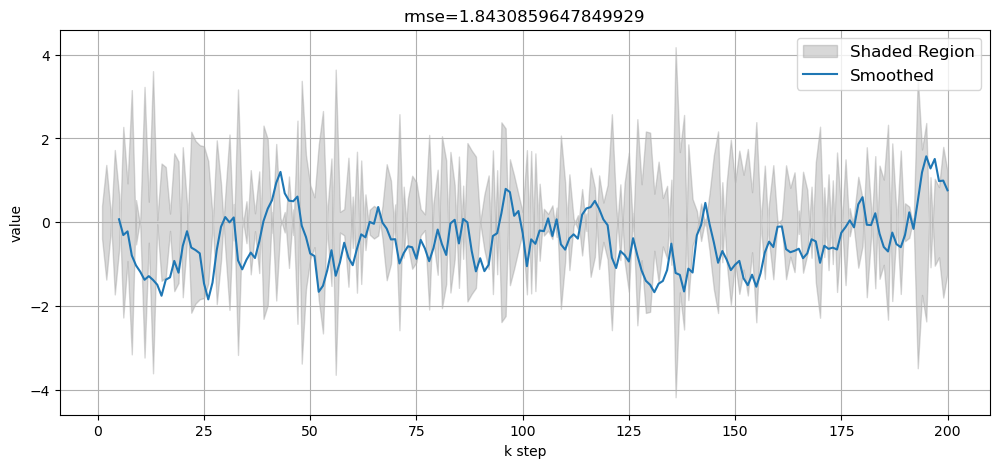

In [23]:

pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm/AE-RNN_None/toy_lgssm_h80_z10_n1_A0_B0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm/AE-RNN_None/data/toy_lgssm_h80_z10_n1_A0_B0.csv"
y_yhat_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 200, start_from=0)

# var-rnn-phy


[-0.49565518 -1.1304687  -0.61903954 ...  4.462914    4.948224
  3.9643989 ] [-0.6183403   0.25413486 -1.1466817  ...  2.7865572   3.6778178
  3.619108  ]
1.5430543422698977


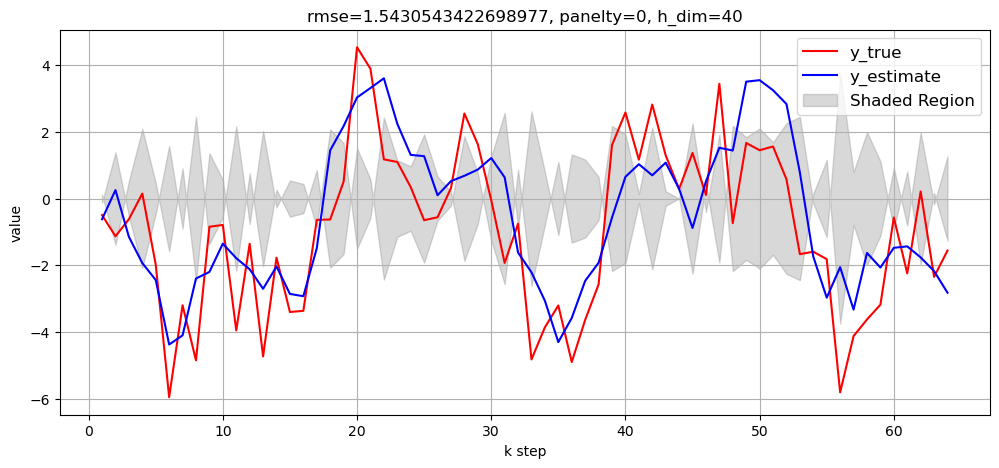

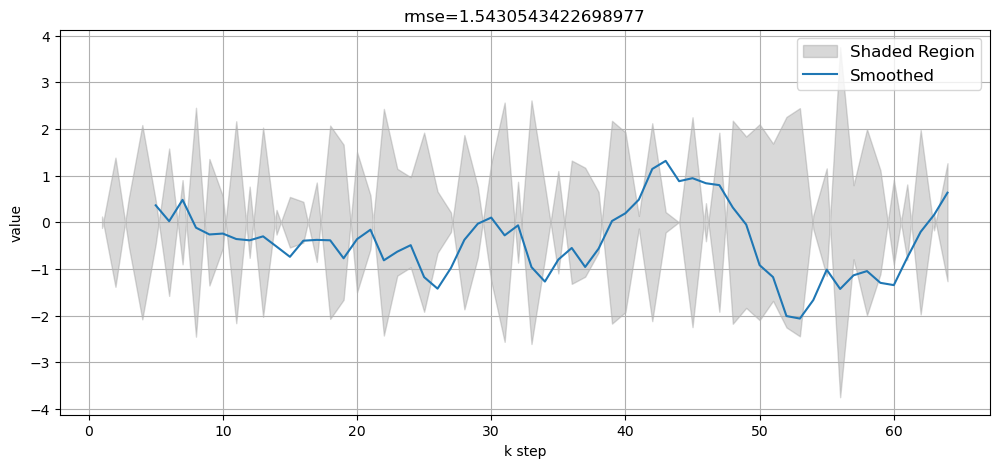

In [27]:

pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/parta0b0/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/toy_lgssm_5_pre_h80_z2_n1_mpw50_A0_B0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/parta0b0/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/data/toy_lgssm_5_pre_h80_z2_n1_mpw50_A0_B0.csv"
y_yhat_nn(pattern, rmse_path,panelty=0,h_dim=40,length = 64, start_from=0)

[-0.49565518 -1.1304687  -0.61903954 ...  4.462914    4.948224
  3.9643989 ] [ 1.013878    1.0152053   1.041131   ... -0.03774927  0.7853611
  1.9083492 ]
2.9448060989379883


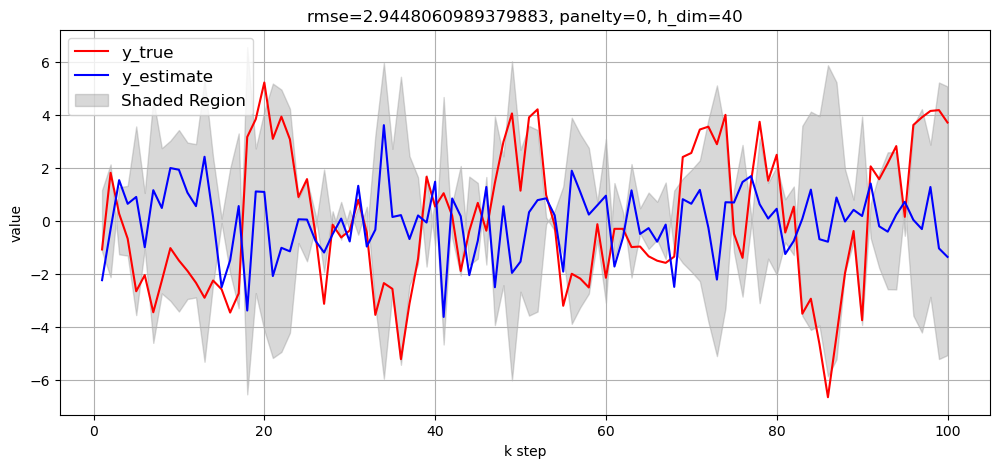

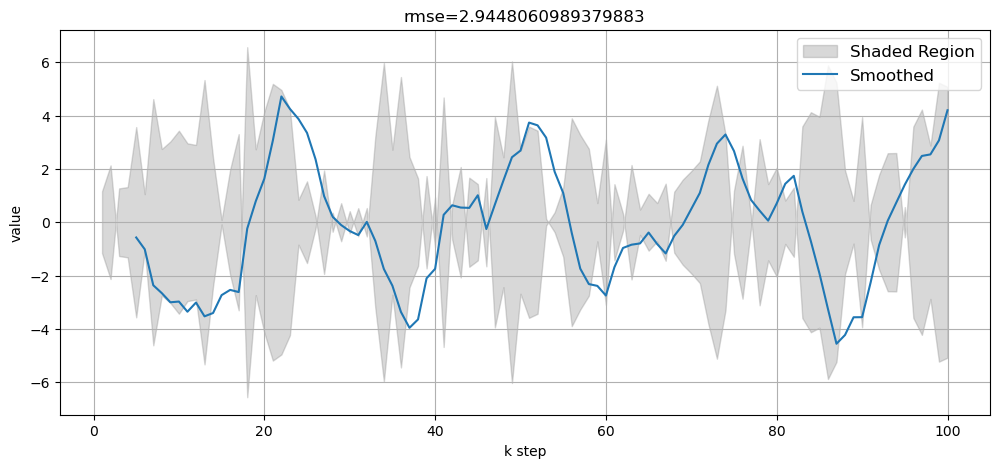

In [3]:


pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prtallknow/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/toy_lgssm_5_pre_h20_z2_n1_mpw10000_A0_B0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prtallknow/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/data/toy_lgssm_5_pre_h20_z2_n1_mpw10000_A0_B0.csv"
y_yhat_nn(pattern, rmse_path,panelty=0,h_dim=40,length = 100, start_from=300)